# IMO zadanie 2 - Lokalne przeszukiwanie

Emilia Maciejewska <br />
Anita Zielińska

In [65]:
import tsplib95
import numpy as np
import math
import random
import matplotlib.pyplot as plt
import datetime

# 0. Wczytywanie danych

In [66]:
problemA = tsplib95.load("kroA100.tsp")
problemA = problemA.as_keyword_dict()

In [67]:
problemB = tsplib95.load("kroB100.tsp")
problemB = problemB.as_keyword_dict()

In [68]:
def create_distance_matrix(data):
    dict_length = len(data['NODE_COORD_SECTION'])
    distance_matrix = np.zeros((dict_length, dict_length), dtype=int)
    for i in range(len(distance_matrix)):
        for j in range(len(distance_matrix[i])):
            x1 = data['NODE_COORD_SECTION'][i+1]
            x2 = data['NODE_COORD_SECTION'][j+1]
            d = math.floor(math.sqrt((x1[0]-x2[0])**2 + (x1[1]-x2[1])**2) + 0.5)
            distance_matrix[i][j] = d
    return distance_matrix

In [69]:
distance_matrix_A = create_distance_matrix(problemA)
distance_matrix_B = create_distance_matrix(problemB)
startingPoints = dict()

# 1.Algorytmy startowe

### Wybór punktów początkowych

In [70]:
def selectStartingPoints(id):
    if id == 'A':
        max_id = max_id = len(distance_matrix_A) - 1 
    else:
        max_id = max_id = len(distance_matrix_B) - 1 
    p1 = random.randint(0, max_id)
    p2 = random.randint(0, max_id)
    while p2 == p1:
        p2 = random.randint(0, max_id)
    return p1, p2

In [71]:
def selectP(experimentId):
    p1 = 0
    p2 = 0
    while True:
        p1, p2 = selectStartingPoints(experimentId)
        sId1 = str(p1)+","+str(p2)
        sId2 = str(p2)+","+str(p1)
        if sId1 not in startingPoints and sId2 not in startingPoints:
            startingPoints[sId1] = 1
            break
    return p1, p2

## 1.1 Algorytm zachłanny jako algorytm startowy

In [72]:
def greedy_start(experimentId, p1, p2):
    matrix_length = 0
    d_matrix = []
    if experimentId == 'A':
        matrix_length = len(distance_matrix_A) 
        d_matrix = distance_matrix_A
    else:
        matrix_length = len(distance_matrix_B)  
        d_matrix = distance_matrix_B
    selected = dict()
    selected[p1] = 1
    selected[p2] = 1
    result = [[p1],[p2]]
    resultVal = [[0],[0]]

    cycleId = 0
    while len(selected) < matrix_length:
        newDist = np.inf
        newArr = []
        newItem = np.inf
        for i in range(matrix_length):
            if i not in selected:
                for j in range(len(result[cycleId])+1):
                    new = result[cycleId][:j]
                    new.append(i)
                    new += result[cycleId][j:]
                    dist = 0
                    for k in range(1, len(new)):
                        dist += d_matrix[new[k-1]][new[k]]
                    if dist < newDist:
                        newDist = dist
                        newArr = new
                        newItem = i
        result[cycleId] = newArr
        resultVal[cycleId] = newDist
        selected[newItem] = 1
        if cycleId == 0:
            cycleId = 1
        else:
            cycleId = 0
    resultVal[0] += d_matrix[result[0][len(result[0]) - 1]][result[0][0]]
    resultVal[1] += d_matrix[result[1][len(result[1]) - 1]][result[1][0]]
    result[0].append(result[0][0])
    result[1].append(result[1][0])
    return result, resultVal

## 1.2 Algorytm losowy jako algorytm startowy

In [73]:
def random_start(experimentId, p1, p2):
    mat = distance_matrix_A if experimentId == 'A' else distance_matrix_B
    matrix_length = len(mat) 
    d_matrix = []

    result = [[],[]]
    resultVal = [[0],[0]]
    cycleId = 0
    for point in sorted(list(range(matrix_length)), key=lambda x:random.random()):
        result[cycleId].append(point)
        if len(result[cycleId]) > 1:
            resultVal[cycleId] += mat[result[cycleId][-2]][result[cycleId][-1]]
        cycleId = 0 if cycleId else 1
        
    resultVal[0] += mat[result[0][-1]][result[0][0]]
    resultVal[1] += mat[result[1][-1]][result[1][0]]
    result[0].append(result[0][0])
    result[1].append(result[1][0]) 
    return result, resultVal

# 2. Lokalne przeszukiwanie metoda steepest

## 2.1 Sąsiedztwo międzytrasowe wierzchołki

In [74]:
def neighborExternalV (experimentId, result, resultVal):
    mat = distance_matrix_A if experimentId == 'A' else distance_matrix_B
    delta = np.inf
    r = []
    aA = np.copy(result[0])
    aB = np.copy(result[1])
    aA = np.append(aA, aA[1])
    aB = np.append(aB, aB[1]) 
    for i in range(1, len(aA)-1):
        for j in range(1, len(aB)-1):
            dis1 = mat[aA[i-1]][aA[i]] + mat[aA[i]][aA[i+1]]
            dis1 += mat[aB[j-1]][aB[j]] + mat[aB[j]][aB[j+1]]
            dis2 = mat[aB[j-1]][aA[i]] + mat[aA[i]][aB[j+1]]
            dis2 += mat[aA[i-1]][aB[j]] + mat[aB[j]][aA[i+1]]
            d = dis2 - dis1
            if d < delta:
                delta = d
                r = [aA[i], aB[j]]
    return delta, r

## 2.2 Sąsiedztwo wewnątrztrasowe wierzchołki

In [75]:
def neighborInternalVSingle (mat, aA, delta, r):
    for i in range(1, len(aA)-1):
        for j in range(i+1,  len(aA)-1):
            dis1 = 0
            dis2 = 0
            if i+1 != j and (i!=1 or j!=50):
                dis1 = mat[aA[i-1]][aA[i]] + mat[aA[i]][aA[i+1]] + mat[aA[j-1]][aA[j]] + mat[aA[j]][aA[j+1]]
                dis2 = mat[aA[i-1]][aA[j]] + mat[aA[j]][aA[i+1]] + mat[aA[j-1]][aA[i]] + mat[aA[i]][aA[j+1]]
                d = dis2 - dis1
                if d < delta:
                    delta = d
                    r = [aA[i], aA[j]]            
    return delta, r

In [76]:
def neighborInternalV (experimentId, result, resultVal):
    mat = distance_matrix_A if experimentId == 'A' else distance_matrix_B
    delta = np.inf
    r = []
    aA = np.copy(result[0])
    aB = np.copy(result[1])
    aA = np.append(aA, aA[1])
    aB = np.append(aB, aB[1]) 
    delta, r = neighborInternalVSingle(mat, aA, delta, r)
    delta, r = neighborInternalVSingle(mat, aB, delta, r)   
    return delta, r

## 2.3 Sąsiedztwo wewnątrztrasowe krawędzie

In [77]:
def neighborInternalESingle (mat, aA, delta, r):
    for i in range(1, len(aA)):
        for j in range(i+1,  len(aA)-1):
            if i+1 != j:
                dis1 = mat[aA[i-1]][aA[i]] + mat[aA[j]][aA[j+1]]
                dis2 = mat[aA[i-1]][aA[j]] + mat[aA[i]][aA[j+1]]
                d = dis2 - dis1
                if d < 0 and d < delta:
                    delta = d
                    r = [aA[i], aA[j]]
    return delta, r

In [78]:
def neighborInternalE (experimentId, result, resultVal):
    mat = distance_matrix_A if experimentId == 'A' else distance_matrix_B
    delta = np.inf
    r = []
    aA = np.copy(result[0])
    aB = np.copy(result[1])
    delta1, r1 = neighborInternalESingle(mat, aA, delta, r)
    delta2, r2 = neighborInternalESingle(mat, aB, delta, r)
    if delta1 < delta2:
        return delta1, r1, "0"
    else:
        return delta2, r2, "1"

## 2.4 Steepest, zewnątrztrasowe i wewnątrztrasowe wierzchołki

In [79]:
def steepestV (experimentId, result, resultVal):
    mat = distance_matrix_A if experimentId == 'A' else distance_matrix_B
    delta = -1
    r = []
    
    while delta < 0:
        newResult = [[],[]]
        newResultVal = [0, 0]
        delta1, r1 = neighborExternalV(experimentId, result, resultVal)
        delta2, r2 = neighborInternalV(experimentId, result, resultVal)
        if delta1 < delta2: # lepsza była zmiana międzytrasowa
            r = r1
            for i in range(len(result)):
                for j in range(len(result[i])):
                    if i == 0 and result[i][j] == r[0]:
                        newResult[i].append(r[1])
                    elif i == 1 and result[i][j] == r[1]:
                        newResult[i].append(r[0])
                    else:
                        newResult[i].append(result[i][j])
                    if len(newResult[i]) > 1:
                        newResultVal[i] += mat[newResult[i][-2]][newResult[i][-1]]
        else:
            r = r2
            for i in range(len(result)):
                for j in range(len(result[i])):
                    if result[i][j] == r[0]:
                        newResult[i].append(r[1])
                    elif result[i][j] == r[1]:
                        newResult[i].append(r[0])
                    else:
                        newResult[i].append(result[i][j])
                    if len(newResult[i]) > 1:
                        newResultVal[i] += mat[newResult[i][-2]][newResult[i][-1]]
        delta = newResultVal[0] + newResultVal[1] - resultVal[0] - resultVal[1]
        result = np.copy(newResult)
        resultVal = np.copy(newResultVal)
    return result, resultVal

## 2.5 Steepest, zewnątrztrasowe i wewnątrztrasowe krawędzie

In [80]:
def steepestE (experimentId, result, resultVal):
    mat = distance_matrix_A if experimentId == 'A' else distance_matrix_B
    delta = -1
    r = []
    
    while delta < 0:
        newResult = [[],[]]
        newResultVal = [0, 0]
        delta1, r1 = neighborExternalV(experimentId, result, resultVal)
        delta2, r2, cycleId = neighborInternalE(experimentId, result, resultVal)
        if delta1 < delta2: # lepsza była zmiana międzytrasowa
            r = r1
            for i in range(len(result)):
                for j in range(len(result[i])):
                    if i == 0 and result[i][j] == r[0]:
                        newResult[i].append(r[1])
                    elif i == 1 and result[i][j] == r[1]:
                        newResult[i].append(r[0])
                    else:
                        newResult[i].append(result[i][j])
                    if len(newResult[i]) > 1:
                        newResultVal[i] += mat[newResult[i][-2]][newResult[i][-1]]
        else:
            r = r2
            tempA = []
            cycleId = int(cycleId)
            index1 = np.where(result[cycleId] == r[0])
            index2 = np.where(result[cycleId] == r[1])
            tempA = np.copy(result[cycleId])
            tempA = tempA[index1[0][0]+1: index2[0][0]]
            
            if cycleId == 1:
                newResultVal[0] = np.copy(resultVal[0])
                newResult[0] = np.copy(result[0])
            else:
                newResultVal[1] = np.copy(resultVal[1])
                newResult[1] = np.copy(result[1])
            
            tempA = np.flip(tempA)
            flag = False
            ind = 0
            for j in range(len(result[cycleId])):
                if result[cycleId][j] == r[0]:
                    newResult[cycleId].append(r[1])
                    ind = 0
                    flag = True
                elif result[cycleId][j] == r[1]:
                    newResult[cycleId].append(r[0])
                    flag = False
                elif flag == True:
                    newResult[cycleId].append(tempA[ind])
                    ind +=1
                else:
                    newResult[cycleId].append(result[cycleId][j])
                if len(newResult[cycleId]) > 1:
                    newResultVal[cycleId] += mat[newResult[cycleId][-2]][newResult[cycleId][-1]]

        delta = newResultVal[0] + newResultVal[1] - resultVal[0] - resultVal[1]
        result = np.copy(newResult)
        resultVal = np.copy(newResultVal)
        
    return result, resultVal

# 3. Lokalne przeszukiwanie metoda greedy

## 3.1 Sąsiedztwo międzytrasowe wierzchołki

In [81]:
def externalVertexGreedy (mat, aA, aB, cR, vR, dR):   
    r = []
    delta = np.inf
    aA = np.copy(aA)
    aB = np.copy(aB)
    aA = np.append(aA, aA[1])
    aB = np.append(aB, aB[1]) 
    if dR == 0:
        for i in range(vR, len(aA)-1):
            for j in range(vR, len(aB)-1):
                dis1 = mat[aA[i-1]][aA[i]] + mat[aA[i]][aA[i+1]]
                dis1 += mat[aB[j-1]][aB[j]] + mat[aB[j]][aB[j+1]]
                dis2 = mat[aB[j-1]][aA[i]] + mat[aA[i]][aB[j+1]]
                dis2 += mat[aA[i-1]][aB[j]] + mat[aB[j]][aA[i+1]]
                d = dis2 - dis1
                if d < 0:
                    r = [aA[i], aB[j]]
                    return d, r, True
        for i in range(1, vR):
            for j in range(1, vR):
                dis1 = mat[aA[i-1]][aA[i]] + mat[aA[i]][aA[i+1]]
                dis1 += mat[aB[j-1]][aB[j]] + mat[aB[j]][aB[j+1]]
                dis2 = mat[aB[j-1]][aA[i]] + mat[aA[i]][aB[j+1]]
                dis2 += mat[aA[i-1]][aB[j]] + mat[aB[j]][aA[i+1]]
                d = dis2 - dis1
                if d < 0:
                    r = [aA[i], aB[j]]
                    return d, r, True
    else:
        for i in range(len(aA)-2, vR+1, -1):
            for j in range(len(aB)-2, vR+1, -1):
                dis1 = mat[aA[i-1]][aA[i]] + mat[aA[i]][aA[i+1]]
                dis1 += mat[aB[j-1]][aB[j]] + mat[aB[j]][aB[j+1]]
                dis2 = mat[aB[j-1]][aA[i]] + mat[aA[i]][aB[j+1]]
                dis2 += mat[aA[i-1]][aB[j]] + mat[aB[j]][aA[i+1]]
                d = dis2 - dis1
                if d < 0:
                    r = [aA[i], aB[j]]
                    return d, r, True
        for i in range(vR-1, 0, -1):
            for j in range(vR-1, 0, -1):
                dis1 = mat[aA[i-1]][aA[i]] + mat[aA[i]][aA[i+1]]
                dis1 += mat[aB[j-1]][aB[j]] + mat[aB[j]][aB[j+1]]
                dis2 = mat[aB[j-1]][aA[i]] + mat[aA[i]][aB[j+1]]
                dis2 += mat[aA[i-1]][aB[j]] + mat[aB[j]][aA[i+1]]
                d = dis2 - dis1
                if d < 0:
                    r = [aA[i], aB[j]]
                    return d, r, True
    return delta, r, False

## 3.2 Sąsiedztwo wewnątrztrasowe wierzchołki

In [82]:
def internalVertexSingle (mat, aA, aB, vR): 
    d = np.inf
    r = []
    for i in range(vR, len(aA)-1):
        for j in range(i+1,  len(aA)-1):
            dis1 = 0
            dis2 = 0
            if i+1 != j and (i!=1 or j!=50):
                dis1 = mat[aA[i-1]][aA[i]] + mat[aA[i]][aA[i+1]] + mat[aA[j-1]][aA[j]] + mat[aA[j]][aA[j+1]]
                dis2 = mat[aA[i-1]][aA[j]] + mat[aA[j]][aA[i+1]] + mat[aA[j-1]][aA[i]] + mat[aA[i]][aA[j+1]]
                d = dis2 - dis1
                if d < 0:
                    r = [aA[i], aA[j]]
                    return d, r, True
    for i in range(1, vR):
        for j in range(i+1,  vR):
            dis1 = 0
            dis2 = 0
            if i+1 != j and (i!=1 or j!=50):
                dis1 = mat[aA[i-1]][aA[i]] + mat[aA[i]][aA[i+1]] + mat[aA[j-1]][aA[j]] + mat[aA[j]][aA[j+1]]
                dis2 = mat[aA[i-1]][aA[j]] + mat[aA[j]][aA[i+1]] + mat[aA[j-1]][aA[i]] + mat[aA[i]][aA[j+1]]
                d = dis2 - dis1
                if d < 0:
                    r = [aA[i], aA[j]]
                    return d, r, True 
                        
    for i in range(1, len(aB)-1):
        for j in range(i+1,  len(aB)-1):
            dis1 = 0
            dis2 = 0
            if i+1 != j and (i!=1 or j!=50):
                dis1 = mat[aB[i-1]][aB[i]] + mat[aB[i]][aB[i+1]] + mat[aB[j-1]][aB[j]] + mat[aB[j]][aB[j+1]]
                dis2 = mat[aB[i-1]][aB[j]] + mat[aB[j]][aB[i+1]] + mat[aB[j-1]][aB[i]] + mat[aB[i]][aB[j+1]]
                d = dis2 - dis1
                if d < 0:
                    r = [aB[i], aB[j]]
                    return d, r, True
    return d, r, False

In [83]:
def internalVertexGreedy (mat, aA, aB, cR, vR, dR):
    r = []
    delta = np.inf
    aA = np.copy(aA)
    aB = np.copy(aB)
    aA = np.append(aA, aA[1])
    aB = np.append(aB, aB[1]) 
    
    if cR == 0:  
        d, r, success = internalVertexSingle (mat, aA, aB, vR)
    elif cR == 1:
        d, r, success = internalVertexSingle (mat, aB, aA, vR)
    return d, r, success


## 3.3 Sąsiedztwo wewnątrztrasowe krawędzie

In [84]:
def internalEdgesSingle (mat, aA, aB, vR):
    d = np.inf
    r = []
    for i in range(vR, len(aA)):
        for j in range(i+1,  len(aA)-1):
            if i+1 != j:
                dis1 = mat[aA[i-1]][aA[i]] + mat[aA[j]][aA[j+1]]
                dis2 = mat[aA[i-1]][aA[j]] + mat[aA[i]][aA[j+1]]
                d = dis2 - dis1
                if d < 0:
                    r = [aA[i], aA[j]]
                    return d, r, True
    for i in range(1, vR):
        for j in range(i+1,  vR-1):
            if i+1 != j:
                dis1 = mat[aA[i-1]][aA[i]] + mat[aA[j]][aA[j+1]]
                dis2 = mat[aA[i-1]][aA[j]] + mat[aA[i]][aA[j+1]]
                d = dis2 - dis1
                if d < 0:
                    r = [aA[i], aA[j]]
                    return d, r, True
    for i in range(1, len(aB)):
        for j in range(i+1,  len(aB)-1):
            if i+1 != j:
                dis1 = mat[aB[i-1]][aB[i]] + mat[aB[j]][aB[j+1]]
                dis2 = mat[aB[i-1]][aB[j]] + mat[aB[i]][aB[j+1]]
                d = dis2 - dis1
                if d < 0:
                    r = [aB[i], aB[j]]
                    return d, r, True
    return d, r, False

In [85]:
def internalEdgesGreedy (mat, aA, aB, cR, vR, dR):
    r = []
    delta = np.inf 
    
    if cR == 0:  
        d, r, success = internalEdgesSingle (mat, aA, aB, vR)
    elif cR == 1:
        d, r, success = internalEdgesSingle (mat, aB, aA, vR)

    return d, r, success


## 3.4 Wybór sąsiedztwa

In [86]:
def neighborGreedy(experimentId, result, typeG):
    mat = distance_matrix_A if experimentId == 'A' else distance_matrix_B
    delta = np.inf
    r = []
    aA = np.copy(result[0])
    aB = np.copy(result[1])
    algoType = random.randint(0, 1) # typ sąsiedztwa sprawdzany na początku
    cycleRandom = random.randint(0, 1) # wybór cyklu od któego zaczynamy
    vertexRandom = random.randint(1, len(mat)/2-1) # wybór pozycji w cyklu, od której zaczynamy
    directionRandom = random.randint(0, 1) # wybór kierunku przeglądania
    
    if typeG == 0:
        if algoType == 0:
            delta, r, success = externalVertexGreedy(mat, aA, aB, cycleRandom, vertexRandom, directionRandom)
            if success == True:
                return delta, r, 0, True
            else:
                delta, r, success = internalVertexGreedy(mat, aA, aB, cycleRandom, vertexRandom, directionRandom) 
                return delta, r, 1, success
        else:
            delta, r, success = internalVertexGreedy(mat, aA, aB, cycleRandom, vertexRandom, directionRandom)
            if success == True:
                return delta, r, 1, True
            else:
                delta, r, success = externalVertexGreedy(mat, aA, aB, cycleRandom, vertexRandom, directionRandom) 
                return delta, r, 0, success 
    else: 
        if algoType == 0:
            delta, r, success = externalVertexGreedy(mat, aA, aB, cycleRandom, vertexRandom, directionRandom)
            if success == True:
                return delta, r, 0, True
            else:
                delta, r, success = internalEdgesGreedy(mat, aA, aB, cycleRandom, vertexRandom, directionRandom) 
                return delta, r, 2, success
        else:
            delta, r, success = internalEdgesGreedy(mat, aA, aB, cycleRandom, vertexRandom, directionRandom)
            if success == True:
                return delta, r, 2, True
            else:
                delta, r, success = externalVertexGreedy(mat, aA, aB, cycleRandom, vertexRandom, directionRandom) 
                return delta, r, 0, success

## 3.5 Obliczanie funkcji celu

In [87]:
def greedyV (experimentId, result, resultVal, typeG):
    mat = distance_matrix_A if experimentId == 'A' else distance_matrix_B
    delta = -1
    r = []
    
    while delta < 0:
        newResult = [[],[]]
        newResultVal = [0, 0]
        delta1, r1, typeA, success = neighborGreedy(experimentId, result, typeG)
        if (success == False):
            return result, resultVal
        
        if typeA == 0: # lepsza była zmiana międzytrasowa
            r = r1
            for i in range(len(result)):
                for j in range(len(result[i])):
                    if i == 0 and result[i][j] == r[0]:
                        newResult[i].append(r[1])
                    elif i == 1 and result[i][j] == r[1]:
                        newResult[i].append(r[0])
                    else:
                        newResult[i].append(result[i][j])
                    if len(newResult[i]) > 1:
                        newResultVal[i] += mat[newResult[i][-2]][newResult[i][-1]]
        elif typeA == 1:
            r = r1
            for i in range(len(result)):
                for j in range(len(result[i])):
                    if result[i][j] == r[0]:
                        newResult[i].append(r[1])
                    elif result[i][j] == r[1]:
                        newResult[i].append(r[0])
                    else:
                        newResult[i].append(result[i][j])
                    if len(newResult[i]) > 1:
                        newResultVal[i] += mat[newResult[i][-2]][newResult[i][-1]]
        elif typeA == 2:
            if r1[0] in result[0]:
                cycleId = 0
            else:
                cycleId = 1
            r = r1
            tempA = []
            index1 = np.where(result[cycleId] == r[0])
            index2 = np.where(result[cycleId] == r[1])
            tempA = np.copy(result[cycleId])
            tempA = tempA[index1[0][0]+1: index2[0][0]]
            
            if cycleId == 1:
                newResultVal[0] = np.copy(resultVal[0])
                newResult[0] = np.copy(result[0])
            else:
                newResultVal[1] = np.copy(resultVal[1])
                newResult[1] = np.copy(result[1])
            
            tempA = np.flip(tempA)
            flag = False
            ind = 0
            for j in range(len(result[cycleId])):
                if result[cycleId][j] == r[0]:
                    newResult[cycleId].append(r[1])
                    ind = 0
                    flag = True
                elif result[cycleId][j] == r[1]:
                    newResult[cycleId].append(r[0])
                    flag = False
                elif flag == True:
                    newResult[cycleId].append(tempA[ind])
                    ind +=1
                else:
                    newResult[cycleId].append(result[cycleId][j])
                if len(newResult[cycleId]) > 1:
                    newResultVal[cycleId] += mat[newResult[cycleId][-2]][newResult[cycleId][-1]]
            
        delta = newResultVal[0] + newResultVal[1] - resultVal[0] - resultVal[1]
        result = np.copy(newResult)
        resultVal = np.copy(newResultVal)
        
    return result, resultVal

# 4. Eksperyment obliczeniowy

In [30]:
resultStartG = []
resultValStartG = []

resultStartR = []
resultValStartR = []

resultA1 = []
resultValA1 = []
timeA1 = []

resultA2 = []
resultValA2 = []
timeA2 = []

resultA3 = []
resultValA3 = []
timeA3 = []

resultA4 = []
resultValA4 = []
timeA4 = []

resultA5 = []
resultValA5 = []
timeA5 = []

resultA6 = []
resultValA6 = []
timeA6 = []

resultA7 = []
resultValA7 = []
timeA7 = []

resultA8 = []
resultValA8 = []
timeA8 = []

In [46]:
def runExperiment(experimentId):
    itersNumber = 100
    
    for i in range(itersNumber):
        p1, p2 = selectP(experimentId)
        
        #seed greedy
        start, startVal = greedy_start(experimentId, p1, p2)
        resultStartG.append(start)
        resultValStartG.append(startVal)
        
        #wierzchołki, wierzchołki
        start_time = datetime.datetime.now()
        r, v = greedyV(experimentId, start, startVal, 0)
        end_time = datetime.datetime.now()
        resultA1.append(r)
        resultValA1.append(v)
        time_diff = (end_time - start_time)
        execution_time = time_diff.total_seconds() * 1000
        timeA1.append(execution_time)
        
        #wierzchołki, krawędzie
        start_time = datetime.datetime.now()
        r, v = greedyV(experimentId, start, startVal, 1)
        end_time = datetime.datetime.now()
        resultA2.append(r)
        resultValA2.append(v)
        time_diff = (end_time - start_time)
        execution_time = time_diff.total_seconds() * 1000
        timeA2.append(execution_time)
        
        #wierzchołki, wierzchołki
        start_time = datetime.datetime.now()
        r,v = steepestV (experimentId, start, startVal)
        end_time = datetime.datetime.now()
        resultA3.append(r)
        resultValA3.append(v)
        time_diff = (end_time - start_time)
        execution_time = time_diff.total_seconds() * 1000
        timeA3.append(execution_time)
    
        #wierzchołki, krawędzie
        start_time = datetime.datetime.now()
        r,v = steepestE (experimentId, start, startVal)
        end_time = datetime.datetime.now()
        resultA4.append(r)
        resultValA4.append(v)
        time_diff = (end_time - start_time)
        execution_time = time_diff.total_seconds() * 1000
        timeA4.append(execution_time)
     
        #seed losowy
        start, startVal = random_start(experimentId, p1, p2)
        resultStartR.append(start)
        resultValStartR.append(startVal)
        
        #wierzchołki, wierzchołki
        start_time = datetime.datetime.now()
        r, v = greedyV(experimentId, start, startVal, 0)
        end_time = datetime.datetime.now()
        resultA5.append(r)
        resultValA5.append(v)
        time_diff = (end_time - start_time)
        execution_time = time_diff.total_seconds() * 1000
        timeA5.append(execution_time)
        
        #wierzchołki, krawędzie
        start_time = datetime.datetime.now()
        r, v = greedyV(experimentId, start, startVal, 1)
        end_time = datetime.datetime.now()
        resultA6.append(r)
        resultValA6.append(v)
        time_diff = (end_time - start_time)
        execution_time = time_diff.total_seconds() * 1000
        timeA6.append(execution_time)
        
        #wierzchołki, wierzchołki
        start_time = datetime.datetime.now()
        r,v = steepestV (experimentId, start, startVal)
        end_time = datetime.datetime.now()
        resultA7.append(r)
        resultValA7.append(v)
        time_diff = (end_time - start_time)
        execution_time = time_diff.total_seconds() * 1000
        timeA7.append(execution_time)
    
        #wierzchołki, krawędzie
        start_time = datetime.datetime.now()
        r,v = steepestE (experimentId, start, startVal)
        end_time = datetime.datetime.now()
        resultA8.append(r)
        resultValA8.append(v)
        time_diff = (end_time - start_time)
        execution_time = time_diff.total_seconds() * 1000
        timeA8.append(execution_time)

In [47]:
startingPoints = dict()
runExperiment('A')

# 5. Wyniki

In [88]:
problemA['NODE_COORD_SECTION']
dataA = []
for i in range(1, len(problemA['NODE_COORD_SECTION'])+1):
    dataA.append(problemA['NODE_COORD_SECTION'][i])
dataArrA = np.array(dataA)

In [89]:
problemB['NODE_COORD_SECTION']
dataB = []
for i in range(1, len(problemB['NODE_COORD_SECTION'])+1):
    dataB.append(problemB['NODE_COORD_SECTION'][i])
dataArrB = np.array(dataB)

In [90]:
def print_plot(data, points, title, fileName):
    f = plt.figure()
    plt.plot(data[:, 0], data[:, 1], "o", linewidth=0, alpha=0.4)
    plt.plot(data[points[0], 0], data[points[0], 1], "o", color='tab:blue',  linewidth=0, alpha=0.6)
    plt.plot(data[points[0], 0], data[points[0], 1], "--", color="tab:cyan", linewidth=1, alpha=2)
    plt.plot(data[points[1], 0], data[points[1], 1], "o", color='tab:red',  linewidth=0, alpha=0.6)
    plt.plot(data[points[1], 0], data[points[1], 1], "--", color="tab:orange", linewidth=1, alpha=2)
    plt.xlabel("x")
    plt.ylabel("y")
    plt.title(title)
    plt.grid(False)
    
    plt.show()
    f.savefig(fileName, bbox_inches='tight')

In [186]:
def summarizeStart(result, resultVal, title, dataArr):
    minA = np.inf
    maxA = 0
    meanA = 0
    minAres = []
    for i in range (len(resultVal)):
        sumItem = resultVal[i][0] + resultVal[i][1]
        if sumItem < minA:
            minA = sumItem
            minAres = result[i]
        if sumItem > maxA:
            maxA = sumItem
        meanA += sumItem
    meanA = meanA/len(resultVal)
    print("wyniki algorytmu")
    print(minA)
    print(maxA)
    print(meanA)
    print_plot(dataArr, minAres, title, title + ".png")
    plt.show()

In [60]:
def summarize(result, resultVal, timeT, title, startA, dataArr):
    minA = np.inf
    maxA = 0
    meanA = 0
    minT = np.inf
    maxT = 0
    meanT = 0
    minAres = []
    minIndex = 0
    for i in range (len(timeT)):
        sumItem = resultVal[i][0] + resultVal[i][1]
        if sumItem < minA:
            minA = sumItem
            minAres = result[i]
            minIndex = i
        if sumItem > maxA:
            maxA = sumItem
        if timeT[i] < minT:
            minT = timeT[i]
        elif timeT[i] > maxT:
            maxT = timeT[i]
        meanT += timeT[i]
        meanA += sumItem
    meanA = meanA/100
    meanT = meanT/100
    print("wyniki algorytmu")
    print(minA)
    print(maxA)
    print(meanA)
    print("czas obliczeń")
    print(minT)
    print(maxT)
    print(meanT)
    print_plot(dataArr, minAres, title, title + ".png")
    plt.show()
    print_plot(dataArr, startA[minIndex], "start"+title, "start"+title + ".png" )

wyniki algorytmu
23660
32134
29270.25


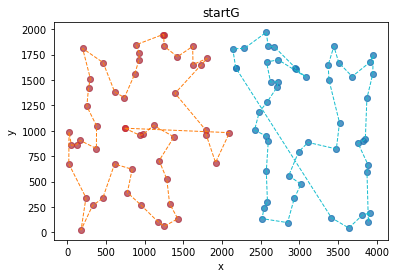

wyniki algorytmu
[149221]
[189654]
[173717.4]


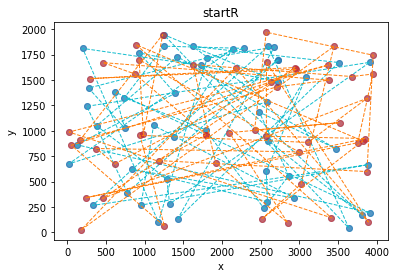

wyniki algorytmu
23547
31995
28300.01
czas obliczeń
13.962
254.31900000000002
56.09014000000002


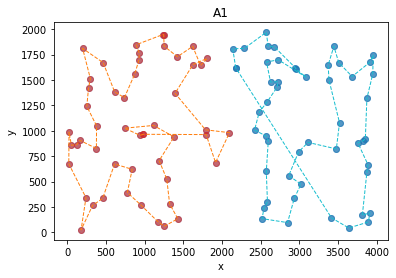

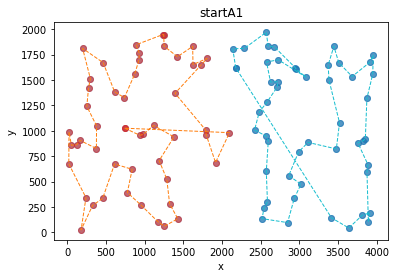

wyniki algorytmu
22281
28791
26639.17
czas obliczeń
15.92
152.592
74.53024000000002


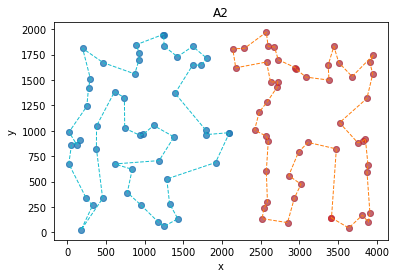

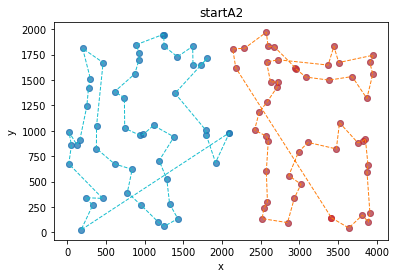

wyniki algorytmu
23180
31249
27767.48
czas obliczeń
37.822
355.04999999999995
170.16866


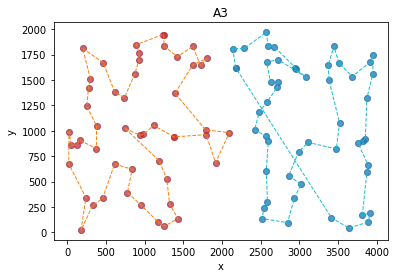

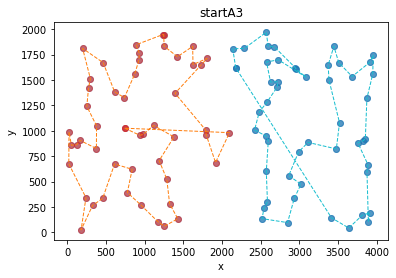

wyniki algorytmu
22570
28498
26299.56
czas obliczeń
73.404
436.834
209.16303000000005


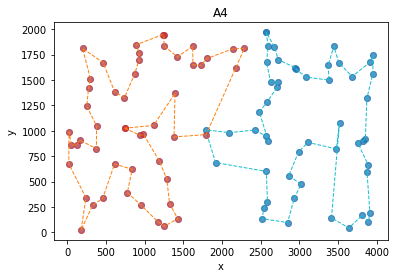

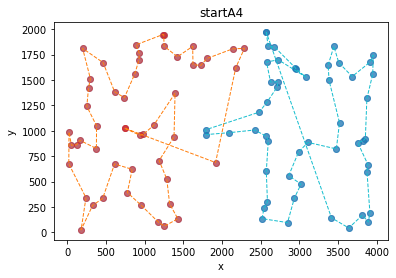

wyniki algorytmu
35275
50803
43573.64
czas obliczeń
216.125
735.035
373.5764200000001


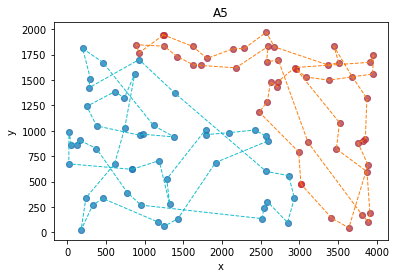

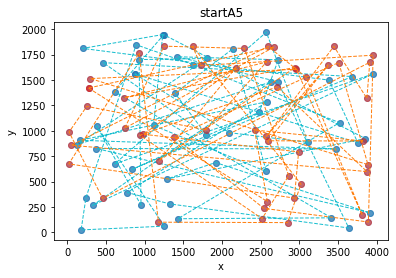

wyniki algorytmu
26443
31635
29718.86
czas obliczeń
141.621
403.414
263.7997400000001


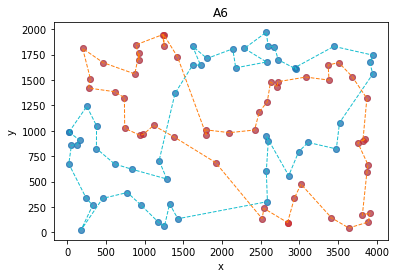

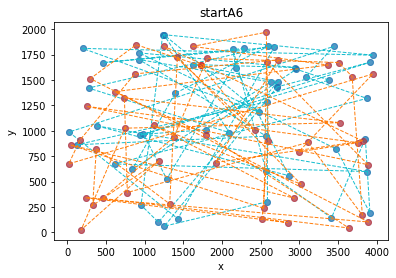

wyniki algorytmu
34289
51678
43575.17
czas obliczeń
1818.137
3379.924
2433.7943099999993


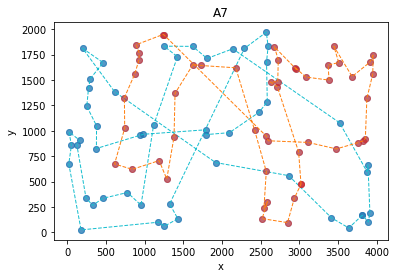

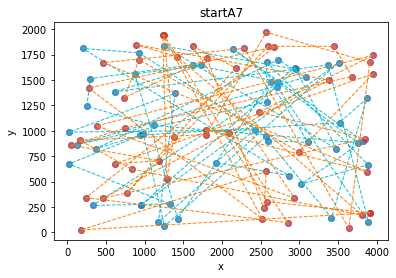

wyniki algorytmu
26381
32189
29637.21
czas obliczeń
1262.6219999999998
1787.188
1525.6799299999996


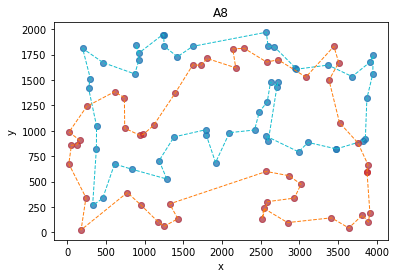

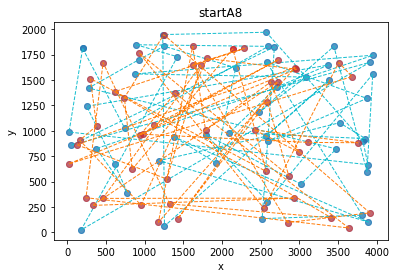

In [53]:
summarizeStart(resultStartG, resultValStartG, "startG", dataArrA)
summarizeStart(resultStartR, resultValStartR, "startR", dataArrA)
summarize(resultA1, resultValA1, timeA1, "A1", resultStartG, dataArrA)
summarize(resultA2, resultValA2, timeA2, "A2", resultStartG, dataArrA)
summarize(resultA3, resultValA3, timeA3, "A3", resultStartG, dataArrA)
summarize(resultA4, resultValA4, timeA4, "A4", resultStartG, dataArrA)
summarize(resultA5, resultValA5, timeA5, "A5", resultStartR, dataArrA)
summarize(resultA6, resultValA6, timeA6, "A6", resultStartR, dataArrA)
summarize(resultA7, resultValA7, timeA7, "A7", resultStartR, dataArrA)
summarize(resultA8, resultValA8, timeA8, "A8", resultStartR, dataArrA)

In [61]:
resultStartG = []
resultValStartG = []

resultStartR = []
resultValStartR = []

resultA1 = []
resultValA1 = []
timeA1 = []

resultA2 = []
resultValA2 = []
timeA2 = []

resultA3 = []
resultValA3 = []
timeA3 = []

resultA4 = []
resultValA4 = []
timeA4 = []

resultA5 = []
resultValA5 = []
timeA5 = []

resultA6 = []
resultValA6 = []
timeA6 = []

resultA7 = []
resultValA7 = []
timeA7 = []

resultA8 = []
resultValA8 = []
timeA8 = []

In [62]:
startingPoints = dict()
runExperiment('B')

wyniki algorytmu
24779
32741
29052.07


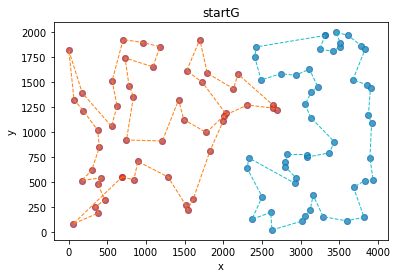

wyniki algorytmu
[142382]
[187773]
[168650.77]


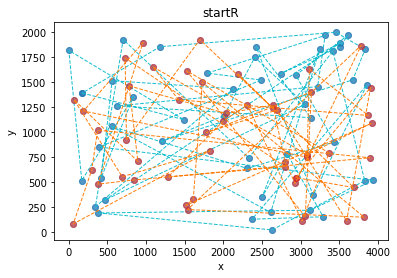

wyniki algorytmu
24536
32238
28246.72
czas obliczeń
19.101
401.571
99.83676999999994


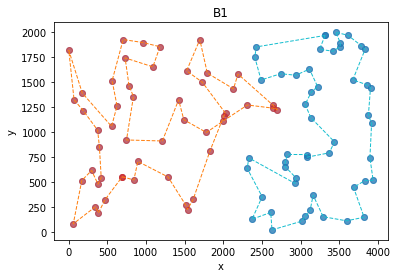

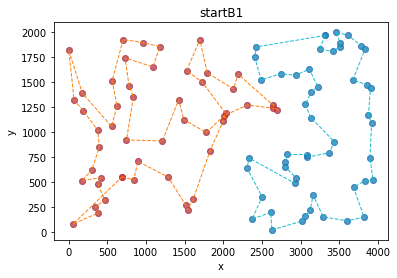

wyniki algorytmu
23698
30170
26556.62
czas obliczeń
16.330000000000002
367.53000000000003
154.43615


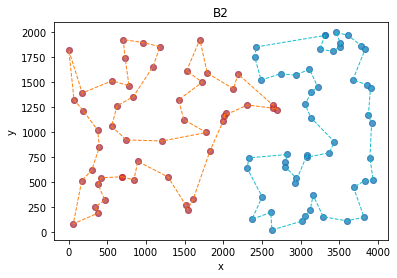

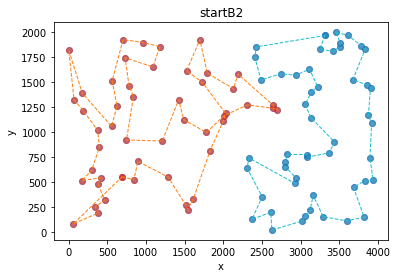

wyniki algorytmu
24539
31599
27906.43
czas obliczeń
24.888
818.985
307.11384999999996


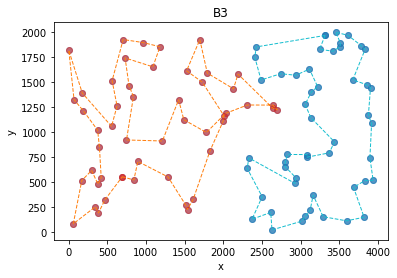

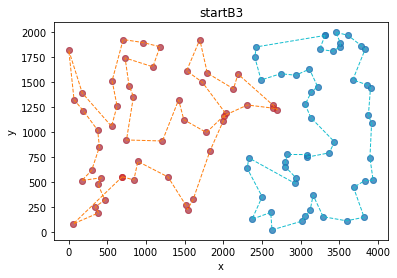

wyniki algorytmu
23781
28992
26168.58
czas obliczeń
100.819
785.8000000000001
454.0384700000002


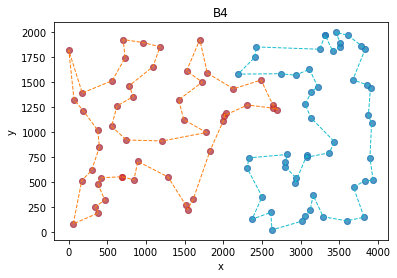

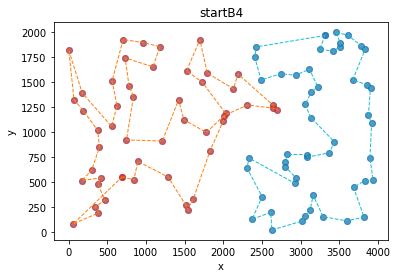

wyniki algorytmu
34011
52141
42548.54
czas obliczeń
295.768
1626.712
745.6605499999998


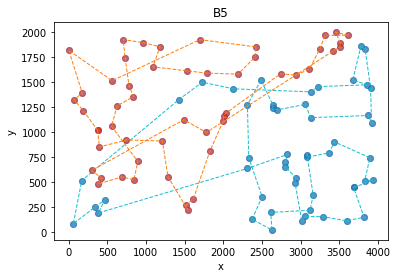

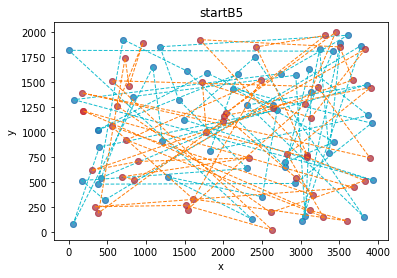

wyniki algorytmu
25739
33282
29729.89
czas obliczeń
215.233
1043.131
518.6514000000001


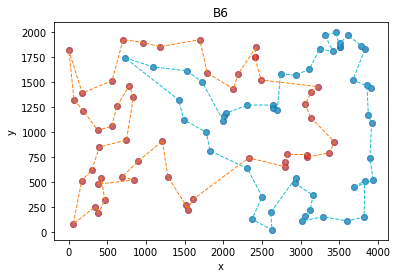

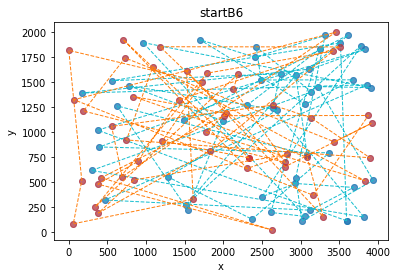

wyniki algorytmu
33176
50383
42978.62
czas obliczeń
2521.82
6696.703
4826.26048


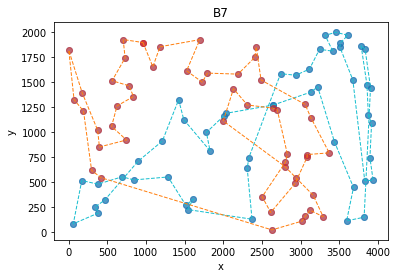

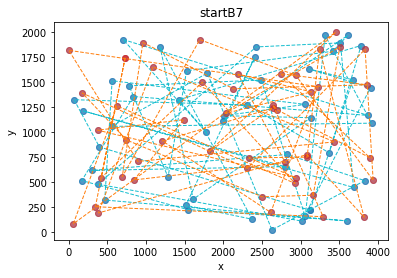

wyniki algorytmu
26947
32353
29289.44
czas obliczeń
1507.891
3900.83
3100.54041


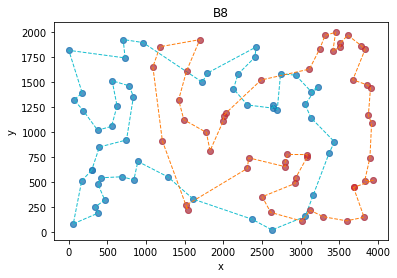

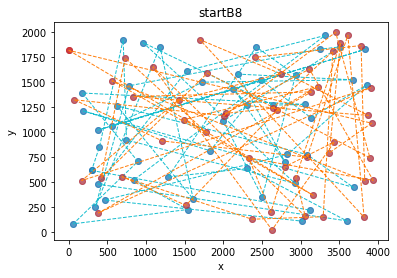

In [63]:
summarizeStart(resultStartG, resultValStartG, "startG", dataArrB)
summarizeStart(resultStartR, resultValStartR, "startR", dataArrB)
summarize(resultA1, resultValA1, timeA1, "B1", resultStartG, dataArrB)
summarize(resultA2, resultValA2, timeA2, "B2", resultStartG, dataArrB)
summarize(resultA3, resultValA3, timeA3, "B3", resultStartG, dataArrB)
summarize(resultA4, resultValA4, timeA4, "B4", resultStartG, dataArrB)
summarize(resultA5, resultValA5, timeA5, "B5", resultStartR, dataArrB)
summarize(resultA6, resultValA6, timeA6, "B6", resultStartR, dataArrB)
summarize(resultA7, resultValA7, timeA7, "B7", resultStartR, dataArrB)
summarize(resultA8, resultValA8, timeA8, "B8", resultStartR, dataArrB)

# 6. Algorytm losowego błądzenia

In [187]:
def randomWalk (experimentId, result, resultVal, timeE):
    mat = distance_matrix_A if experimentId == 'A' else distance_matrix_B
    delta = -1
    r = []
    bestResult = np.copy(result)
    bestResultVal = np.copy(resultVal)
    start_time = datetime.datetime.now()
    end_time = datetime.datetime.now()
    time_diff = (end_time - start_time)
    execution_time = time_diff.total_seconds() * 1000
    
    while execution_time < timeE:
        r = []
        newResult = [[],[]]
        newResultVal = [0, 0]
        algoType = random.randint(0, 1) 
        vR1 = random.randint(1, len(mat)//4-1) 
        vR2 = random.randint(vR1+1, len(mat)/2-1) 
        cycleId = random.randint(0,1)
        if(algoType == 0):
            typeA = 0
            r.append(result[0][vR1])
            r.append(result[1][vR2])
        else:
            typeA = algoType - 1
            r.append(result[cycleId][vR1])
            r.append(result[cycleId][vR2])
        if typeA == 0:
            for i in range(len(result)):
                for j in range(len(result[i])):
                    if result[i][j] == r[0]:
                        newResult[i].append(r[1])
                    elif result[i][j] == r[1]:
                        newResult[i].append(r[0])
                    else:
                        newResult[i].append(result[i][j])
                    if len(newResult[i]) > 1:
                        newResultVal[i] += mat[newResult[i][-2]][newResult[i][-1]]

        delta = newResultVal[0] + newResultVal[1] - bestResultVal[0] - bestResultVal[1]
        result = np.copy(newResult)
        resultVal = np.copy(newResultVal)
        if delta < 0:
            bestResult = np.copy(newResult)
            bestResultVal = np.copy(newResultVal)
        end_time = datetime.datetime.now()
        time_diff = (end_time - start_time)
        execution_time = time_diff.total_seconds() * 1000
        
    return bestResult, bestResultVal

In [193]:
def runExperimentRandom(experimentId, timeE):
    itersNumber = 100
    
    for i in range(itersNumber):
        p1, p2 = selectP(experimentId)
        
        #seed losowy
        start, startVal = random_start(experimentId, p1, p2)
        r,v = randomWalk (experimentId, start, startVal, timeE)
        resultRandomWalk.append(r)
        resultValRandomWalk.append(v)

In [194]:
resultRandomWalk = []
resultValRandomWalk = []

wyniki algorytmu
130478
147355
140876.03


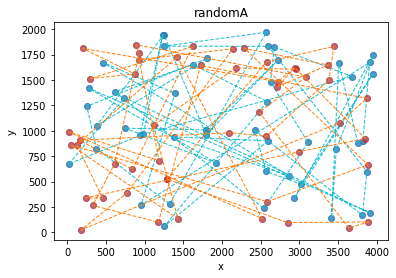

In [195]:
startingPoints = dict()
runExperimentRandom('A', 2500)
summarizeStart(resultRandomWalk, resultValRandomWalk, "randomA", dataArrA)

In [196]:
resultRandomWalk = []
resultValRandomWalk = []

wyniki algorytmu
130266
144628
139124.13


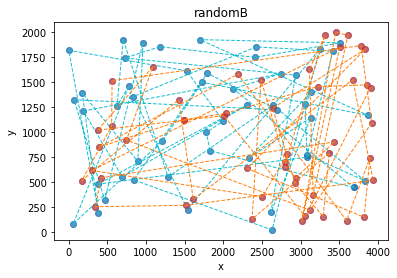

In [197]:
startingPoints = dict()
runExperimentRandom('B', 3000)
summarizeStart(resultRandomWalk, resultValRandomWalk, "randomB", dataArrB)